# Imports

In [7]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import math
from PIL import Image
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split


import wandb
from wandb.keras import WandbCallback

SyntaxError: invalid syntax (<ipython-input-7-e47e0a4d7256>, line 21)

# Tensorflow imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Check if GPU/CPU is connected

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1318380974466239251
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6646509023702856159
physical_device_desc: "device: XLA_CPU device"
]


# Dataset exploration

Total number of categories: 5
Total number of images in dataset: 1470


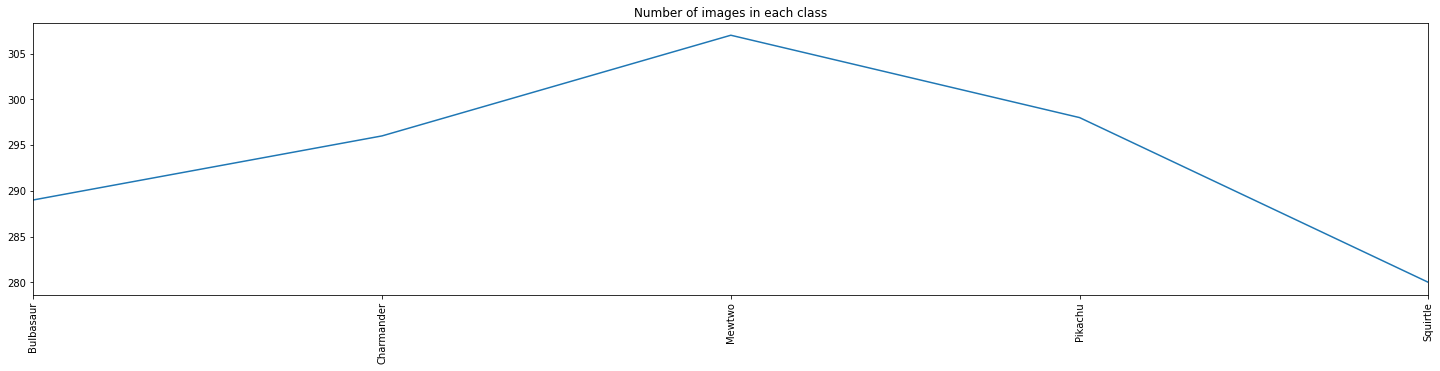

[('Mewtwo', 307), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [8]:
# A little bit of data exploration
path = 'test_dataset/' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

In [8]:
X = [] # List for images
Y = [] # List for labels

pkmn_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(96, 96),
    shuffle=False,
    seed=None,
    validation_split=0.05,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

# X = pkmn_dataset.list_files()
# Y = 

8535  ]],

        [[155.40625  , 226.       , 156.       ],
         [155.66049  , 225.78125  , 155.78125  ],
         [155.       , 227.       , 154.       ],
         ...,
         [147.972    , 226.014    , 150.       ],
         [148.       , 226.       , 151.       ],
         [143.448    , 226.448    , 147.1035   ]]],


       [[[234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ],
         ...,
         [234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ]],

        [[234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ],
         ...,
         [234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ],
         [234.       , 248.       , 189.       ]],

        [[234.       , 248.       , 189

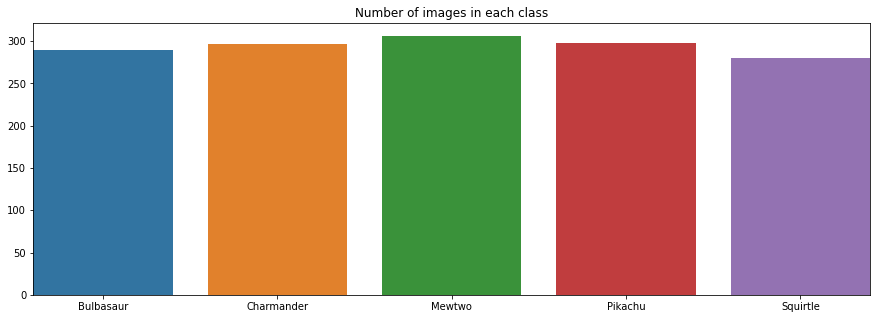

In [6]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [7]:
# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

Found 1466 images belonging to 5 classes.


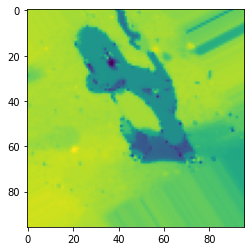

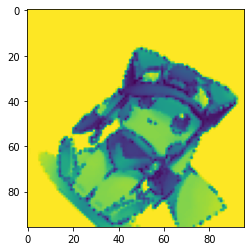

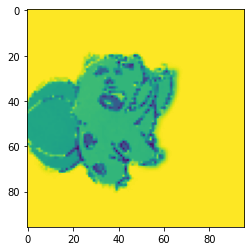

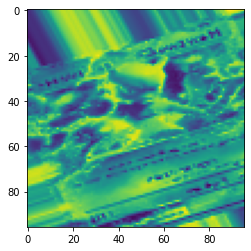

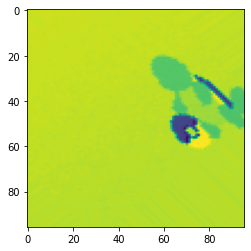

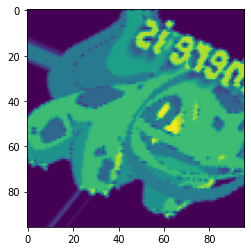

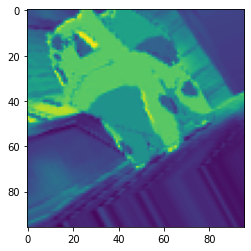

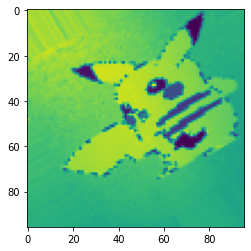

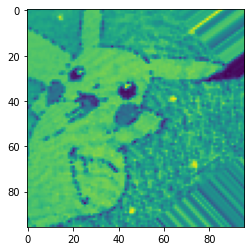

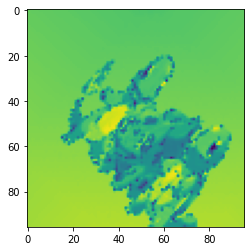

In [14]:
# Defining ImageDataGenerator Iinstance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2
                            ) # Shear Intensity

train_generator = datagen.flow_from_directory(
    path,
    target_size=(96,96),
    batch_size=32,
    color_mode="grayscale",
    classes=None,
    class_mode="categorical",
    save_to_dir="output/",
    save_prefix="test",
    follow_links=False,
    subset=None
)

x,y = train_generator.next()
for i in range(0,10):
    image = x[i]
    plt.imshow(np.array(image, np.int32))
    plt.show()

# Define hyperparameters for sweep

In [9]:
sweep_config = {
  "name": "NN-zadanie2-test-sweep",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop','Adagrad']
        },

    'loss': {
        'values': ['categorical_crossentropy','poisson']
        },


    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(16),
        'max': math.log(64),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':20,
        'max': 100,
        }
    }   

}

In [10]:
wandb.init(project="NN-zadanie2")
sweep_id = wandb.sweep(sweep_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ramang (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
Create sweep with ID: tqejkd1e
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/tqejkd1e


In [11]:
def getOpt(name,rl):

    if name ==  'Adam':
        return keras.optimizers.Adam(learning_rate=rl)
    elif name =='SGD':
        return keras.optimizers.SGD(learning_rate=rl)
    elif name =='RMSprop':
        return keras.optimizers.RMSprop(learning_rate=rl)
    else:
        return keras.optimizers.Adagrad(learning_rate=rl)

def train():
        with wandb.init(config=sweep_config):
        # Specify the other hyperparameters to the configuration
            config = wandb.config
            # Add the config item (layers) to wandb
            if wandb.run:
                # Define the model
                model = Sequential()
                model.add(GaussianNoise(input_shape = (96, 96, 3)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                # model.summary()
                # callbacks
                #checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   

In [12]:
# spustenie sweepu
wandb.agent(sweep_id, function=train, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: s80ekmlm with config:
wandb: 	batch_size: 34
wandb: 	epochs: 81
wandb: 	learning_rate: 0.04937455597375913
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: RMSprop


Epoch 1/81
34/34 [==============================] - 3s 84ms/step - loss: 4.6303 - accuracy: 0.2770 - val_loss: 6132.2759 - val_accuracy: 0.2075
Epoch 2/81
34/34 [==============================] - 2s 62ms/step - loss: 2.1560 - accuracy: 0.3436 - val_loss: 303.4477 - val_accuracy: 0.2075
Epoch 3/81
34/34 [==============================] - 2s 59ms/step - loss: 1.7297 - accuracy: 0.3979 - val_loss: 1085.0004 - val_accuracy: 0.2415
Epoch 4/81
34/34 [==============================] - 2s 62ms/step - loss: 1.4770 - accuracy: 0.4382 - val_loss: 92.5182 - val_accuracy: 0.3844
Epoch 5/81
34/34 [==============================] - 2s 62ms/step - loss: 1.3086 - accuracy: 0.4961 - val_loss: 87.6092 - val_accuracy: 0.4082
Epoch 6/81
34/34 [==============================] - 2s 59ms/step - loss: 1.2810 - accuracy: 0.5478 - val_loss: 151.1501 - val_accuracy: 0.2551
Epoch 7/81
34/34 [==============================] - 2s 62ms/step - loss: 1.1456 - accuracy: 0.5741 - val_loss: 22.9452 - val_accuracy: 0.4762


epoch,20
loss,0.83463
accuracy,0.74145
val_loss,7.59167
val_accuracy,0.61905
_runtime,72
_timestamp,1618238977
_step,20
best_val_loss,1.07416
best_epoch,19


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▂▃▃▄▅▅▆▇▆▇▇▇▇█▇█████
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▃▄▂▄▂▅▅▄▅▅▅▆▆▇▆▅█▆
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▆▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▆▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: f19p6m8c with config:
wandb: 	batch_size: 30
wandb: 	epochs: 64
wandb: 	learning_rate: 0.08981537650376127
wandb: 	loss: poisson
wandb: 	optimizer: Adam


Epoch 1/64
39/39 [==============================] - 4s 102ms/step - loss: 1.1685 - accuracy: 0.3345 - val_loss: 2.4139 - val_accuracy: 0.3095
Epoch 2/64
39/39 [==============================] - 3s 86ms/step - loss: 0.7645 - accuracy: 0.4131 - val_loss: 2.3333 - val_accuracy: 0.3299
Epoch 3/64
39/39 [==============================] - 3s 84ms/step - loss: 0.5693 - accuracy: 0.5048 - val_loss: 3.1422 - val_accuracy: 0.0204
Epoch 4/64
39/39 [==============================] - 4s 92ms/step - loss: 0.4660 - accuracy: 0.5590 - val_loss: 1.4911 - val_accuracy: 0.3741
Epoch 5/64
39/39 [==============================] - 4s 94ms/step - loss: 0.4208 - accuracy: 0.5721 - val_loss: 1.1665 - val_accuracy: 0.3980
Epoch 6/64
39/39 [==============================] - 3s 87ms/step - loss: 0.4166 - accuracy: 0.6218 - val_loss: 0.9062 - val_accuracy: 0.5204
Epoch 7/64
39/39 [==============================] - 3s 89ms/step - loss: 0.4427 - accuracy: 0.5790 - val_loss: 2.8485 - val_accuracy: 0.1224
Epoch 8/64
3

epoch,13
loss,0.56662
accuracy,0.62009
val_loss,1.85749
val_accuracy,0.40476
_runtime,56
_timestamp,1618239042
_step,13
best_val_loss,0.67256
best_epoch,8


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▄▃▂▁▁▁▁▁▁▁▁▂▃
accuracy,▁▃▄▅▆▇▆▅▆▇██▇▇
val_loss,▆▆█▃▂▂▇▃▁▂▁▁▃▄
val_accuracy,▅▅▁▅▆▇▂▇▇█▇▇█▆
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: tat73e9j with config:
wandb: 	batch_size: 52
wandb: 	epochs: 85
wandb: 	learning_rate: 0.0693285165935434
wandb: 	loss: sparse_categorical_crossentropy
wandb: 	optimizer: Adam


Epoch 1/85


wandb: ERROR Run tat73e9j errored: InvalidArgumentError()
wandb: Agent Starting Run: n6c82bqq with config:
wandb: 	batch_size: 45
wandb: 	epochs: 61
wandb: 	learning_rate: 0.03593212753847147
wandb: 	loss: sparse_categorical_crossentropy
wandb: 	optimizer: RMSprop


Epoch 1/61


wandb: ERROR Run n6c82bqq errored: InvalidArgumentError()
wandb: Agent Starting Run: zax0ag35 with config:
wandb: 	batch_size: 30
wandb: 	epochs: 37
wandb: 	learning_rate: 0.014467111515871113
wandb: 	loss: categorical_crossentropy
wandb: 	optimizer: Adagrad


Epoch 1/37
39/39 [==============================] - 3s 69ms/step - loss: 1.6333 - accuracy: 0.4821 - val_loss: 3.2049 - val_accuracy: 0.4048
Epoch 2/37
39/39 [==============================] - 2s 62ms/step - loss: 0.9708 - accuracy: 0.6646 - val_loss: 1.5330 - val_accuracy: 0.5544
Epoch 3/37
39/39 [==============================] - 2s 62ms/step - loss: 0.9970 - accuracy: 0.6786 - val_loss: 1.1851 - val_accuracy: 0.6769
Epoch 4/37
39/39 [==============================] - 2s 64ms/step - loss: 0.7429 - accuracy: 0.7485 - val_loss: 0.4199 - val_accuracy: 0.8878
Epoch 5/37
39/39 [==============================] - 2s 62ms/step - loss: 0.6638 - accuracy: 0.7808 - val_loss: 0.5394 - val_accuracy: 0.8231
Epoch 6/37
39/39 [==============================] - 2s 59ms/step - loss: 0.6386 - accuracy: 0.7860 - val_loss: 0.8432 - val_accuracy: 0.7007
Epoch 7/37
39/39 [==============================] - 2s 58ms/step - loss: 0.6031 - accuracy: 0.8035 - val_loss: 0.6105 - val_accuracy: 0.8061
Epoch 8/37
39

epoch,17
loss,0.41602
accuracy,0.86638
val_loss,0.32829
val_accuracy,0.88435
_runtime,50
_timestamp,1618239120
_step,17
best_val_loss,0.30305
best_epoch,13


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
accuracy,▁▄▅▆▆▆▇▇▇▇▇███████
val_loss,█▄▃▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅█▇▅▇▆▅▇▇▇▇██▇██
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇█
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


In [13]:
# model = Sequential()
# model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(256, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(len(imbalanced), activation = 'softmax'))

# # model.summary()

# checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
# earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# history = model.fit(datagen.flow(X_train, y_train, batch_size = 16), epochs = 20, validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // 16, callbacks = [checkpoint,earlyStoppingCallback])                             

In [14]:
# # Plot learning curves
# fig = plt.figure(figsize = (17, 4))
    
# plt.subplot(121)
# plt.plot(history.history['accuracy'], label = 'acc')
# plt.plot(history.history['val_accuracy'], label = 'val_acc')
# plt.legend()
# plt.grid()
# plt.title(f'accuracy')

# plt.subplot(122)
# plt.plot(history.history['loss'], label = 'loss')
# plt.plot(history.history['val_loss'], label = 'val_loss')
# plt.legend()
# plt.grid()
# plt.title(f'loss')